Je tente en utilisant les instructions dans oml2 et oml3 de faire des requetes sur les le secteur des cimentiers

In [1]:
from pyeutl.orm import DataAccessLayer

connectionSettings = dict(
    user="postgres", 
    host="localhost", 
    db="eutl2024", 
    passw="password",
    port=5432
)



- Rajouter dans PATH des variables système le lien vers POSTGRES:
`C:\Program Files\PostgreSQL\17\bin`
- Puis lancer cette commande dans le terminal pour s'assurer du bon fonctionnement des credentials donnés ci-dessus et de POSTGRES:
`psql -h localhost -p 5432 -U postgres -W`

- Si le code d'en dessous ne fonctionne toujours pas, créer une base de données appelée EU ETL
en relançant:
``psql -h localhost -p 5432 -U postgres -W``

puis en entrant le mdp: password et puis en compilant:
postgres=#`CREATE DATABASE eutl2024`;

-> j'ai appuyé sur echap lors du pop up qui demande si il peut supprimer les tables existantes (mais peut etre inutile vue qu'il n'y a pas de tables dans eutl2024)



In [2]:
#création de la base de données
dal = DataAccessLayer(**connectionSettings)
#creation de la base


In [3]:
dal.create_database()

No source file provided. Download data from euets.info
#### Tables still in database ####
---- Insert lookup tables
Some entries not inserted into nace_code due to key duplication.
Some entries not inserted into compliance_code due to key duplication.
Some entries not inserted into country_code due to key duplication.
Some entries not inserted into unit_type due to key duplication.
Some entries not inserted into activity_type_code due to key duplication.
Some entries not inserted into account_type_code due to key duplication.
Some entries not inserted into transaction_type_supplementary_code due to key duplication.
Some entries not inserted into transaction_type_main_code due to key duplication.
Some entries not inserted into trading_system_code due to key duplication.
---- Insert offset projects


UniqueViolation: ERREUR:  la valeur d'une clé dupliquée rompt la contrainte unique « offset_project_pkey »
DETAIL:  La clé « (id)=(164) » existe déjà.
CONTEXT:  COPY offset_project, ligne 1


In [4]:
from pyeutl.orm import Installation       # EUETS Installation object
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

session = dal.session

## Partie 1: Cimentiers

In [5]:
from pyeutl.orm import NaceCode
from sqlalchemy import select,func
session.rollback()  # Annule la transaction en cours


In [6]:
from pyeutl.orm import Installation, Transaction,Account

stmt = select(Installation.id).where(Installation.nace_id == "23.51")
cement_installation_ids = session.scalars(stmt).all()

print(f"Installations liées au NACE 23.51 : {len(cement_installation_ids)}")


Installations liées au NACE 23.51 : 306


In [7]:
stmt = select(Account.id).where(Account.installation_id.in_(cement_installation_ids))
cement_account_ids = session.scalars(stmt).all()

print(f" Comptes liés aux installations cimentières : {len(cement_account_ids)}")


 Comptes liés aux installations cimentières : 585


In [8]:
stmt = select(
    func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.acquiringAccount_id.in_(cement_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
cement_acquiring_amounts = session.execute(stmt).fetchall()

print(f"Transactions aquisitions liées aux comptes de cimentiers : {cement_acquiring_amounts}")


Transactions aquisitions liées aux comptes de cimentiers : [(Decimal('2005'), Decimal('96549992')), (Decimal('2006'), Decimal('228448629')), (Decimal('2007'), Decimal('175344449')), (Decimal('2008'), Decimal('249789363')), (Decimal('2009'), Decimal('205596087')), (Decimal('2010'), Decimal('226149636')), (Decimal('2011'), Decimal('243529860')), (Decimal('2012'), Decimal('257476583')), (Decimal('2013'), Decimal('96342330')), (Decimal('2014'), Decimal('304091369')), (Decimal('2015'), Decimal('164973993')), (Decimal('2016'), Decimal('153008360')), (Decimal('2017'), Decimal('152221148')), (Decimal('2018'), Decimal('150270122')), (Decimal('2019'), Decimal('152682502')), (Decimal('2020'), Decimal('162552671')), (Decimal('2021'), Decimal('71120591'))]


In [9]:
stmt = select(func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.transferringAccount_id.in_(cement_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
cement_sending_amounts = session.execute(stmt).fetchall()

print(f"Transactions transfert liées aux comptes de cimentiers : {cement_sending_amounts}")


Transactions transfert liées aux comptes de cimentiers : [(Decimal('2005'), Decimal('3731703')), (Decimal('2006'), Decimal('177388117')), (Decimal('2007'), Decimal('168395349')), (Decimal('2008'), Decimal('284013233')), (Decimal('2009'), Decimal('209185354')), (Decimal('2010'), Decimal('229630091')), (Decimal('2011'), Decimal('248625118')), (Decimal('2012'), Decimal('239326358')), (Decimal('2013'), Decimal('191910252')), (Decimal('2014'), Decimal('217667449')), (Decimal('2015'), Decimal('163739439')), (Decimal('2016'), Decimal('162467114')), (Decimal('2017'), Decimal('143171833')), (Decimal('2018'), Decimal('153653519')), (Decimal('2019'), Decimal('158572721')), (Decimal('2020'), Decimal('159556744')), (Decimal('2021'), Decimal('143248735'))]


1) Les allocations du marché primaire, mise aux en enchères:
amount avec transferringAccount dans cette liste:
- ICE UK Auction Trust Account -DECC
- ECC AG Handel
- ECC AG Handel Backup
- ECC Luxembourg SARL Primärhandel



In [10]:
#recupérer les IDS des comptes institutionnels 

institution_names = [
    "UK Auction Trust Account - DECC",
    "ECC AG Handel",
    "ECC AG Handel Backup",
    "ECC Luxemburg Sarl Primärhandel"
]

# Requête pour récupérer les account_id correspondants
stmt = select(Account.id).where(Account.name.in_(institution_names))
institution_accounts_ids = session.scalars(stmt).all()
institution_accounts_ids

[106390, 106468, 106346, 106347]

In [11]:
# 🔹 Requête pour obtenir le nombre de transactions et la somme des montants par année
stmt = select(
    func.extract('year', Transaction.date).label("year"),  # Extraction de l'année
    func.count(Transaction.id).label("transaction_count"),  # Nombre de transactions
    func.sum(Transaction.amount).label("total_amount")  # Somme des montants
).where(
    Transaction.transferringAccount_id.in_(institution_accounts_ids)  # Correction du champ
).group_by(
    func.extract('year', Transaction.date)  # Regrouper par année
).order_by(
    func.extract('year', Transaction.date)  # Trier par année
)

# 🔹 Exécution de la requête
institutions_transactions = session.execute(stmt).fetchall()

# 🔹 Affichage des résultats
for inst in institutions_transactions:
    print(f" Année: {inst[0]} |  Nb de transferts: {inst[1]} |  Somme des transferts: {inst[2]}")


 Année: 2012 |  Nb de transferts: 249 |  Somme des transferts: 144789283
 Année: 2013 |  Nb de transferts: 2049 |  Somme des transferts: 879271586
 Année: 2014 |  Nb de transferts: 1633 |  Somme des transferts: 650569634
 Année: 2015 |  Nb de transferts: 1606 |  Somme des transferts: 687410667
 Année: 2016 |  Nb de transferts: 1983 |  Somme des transferts: 795655187
 Année: 2017 |  Nb de transferts: 1927 |  Somme des transferts: 1007313194
 Année: 2018 |  Nb de transferts: 2124 |  Somme des transferts: 1058901054
 Année: 2019 |  Nb de transferts: 2007 |  Somme des transferts: 734710610
 Année: 2020 |  Nb de transferts: 2183 |  Somme des transferts: 843192222
 Année: 2021 |  Nb de transferts: 1777 |  Somme des transferts: 467609193


Remarque 1: Très peu de transaction en nombre de la part des institutions ...?

Remarque 2: Ne commencent qu'en 2012?? 


In [12]:
#dans la liste des transactions de cimentier, recupérer les transactions avec
# les transfering account = institutions
stmt = select(Transaction.id).where(
    (Transaction.acquiringAccount_id.in_(institution_accounts_ids)) 
    &(Transaction.acquiringAccount_id.in_(cement_account_ids))
)
#
# Exécution de la requête
cement_allocations_id = session.scalars(stmt).all()
cement_allocations_id


[]

-> Pas d'achat sur le marché primaire pour les cimentiers ?

Allocations gratuites:

In [13]:
from pyeutl.orm import Compliance

from sqlalchemy import func
stmt = select(
    Compliance.year,  # Group by year
    func.sum(Compliance.allocatedTotal)  # Sum of allocatedTotal
).where(Compliance.installation_id.in_(cement_installation_ids)).group_by(Compliance.year).order_by(Compliance.year)

# Exécution de la requête
cement_allocation_free_amount = session.execute(stmt).fetchall()
print(cement_allocation_free_amount[:100])

[(2005, 154923557), (2006, 153998306), (2007, 164650197), (2008, 175593363), (2009, 176877004), (2010, 177577397), (2011, 177429573), (2012, 178920716), (2013, 140369930), (2014, 127346436), (2015, 126357518), (2016, 126269932), (2017, 122253151), (2018, 119133395), (2019, 118402668), (2020, 115867744), (2021, 95908534), (2022, 96324415), (2023, 96504330), (2024, 93930256), (2025, 93930256), (2026, 0), (2027, 0), (2028, 0), (2029, 0), (2030, 0)]


Emissions emises :

In [14]:
from pyeutl.orm import Surrender

smt = select( Surrender.year ,func.sum(Surrender.amount)
             ).where(
                 Surrender.installation_id.in_(cement_installation_ids) 
             ).group_by(Surrender.year).order_by(Surrender.year)
cement_emissions_amount = session.execute(smt).fetchall()
print(cement_emissions_amount)


[(2005, 107721245), (2006, 188733096), (2007, 165435663), (2008, 155380174), (2009, 132275858), (2010, 123928165), (2011, 116785844), (2012, 97546288), (2013, 112086086), (2014, 117104328), (2015, 114805273), (2016, 115734815), (2017, 118196692), (2018, 119769616), (2019, 119765316), (2020, 112705566), (2021, 109923093), (2022, 101970934), (2023, 94427540), (2024, 187736)]


Remarque 3: L'année devrait commencer le 1er mai en t en finir en 30 avril en t+1 mais Surrender, Compliance ne nous donnent qu'une année pas de mois, jours 

idée: aller relire Description EUTL pour voir si infos sur le "calcul" de l'année

In [23]:
import pandas as pd

#  Transformer chaque liste de tuples en DataFrame
df_acquiring = pd.DataFrame(cement_acquiring_amounts, columns=["Year", "Acquiring Amount"])
df_sending = pd.DataFrame(cement_sending_amounts, columns=["Year", "Sending Amount"])
df_allocation = pd.DataFrame(cement_allocation_free_amount, columns=["Year", "Allocated Free Amount"])
df_emissions = pd.DataFrame(cement_emissions_amount, columns=["Year", "Emissions Amount"])

#  Fusionner les DataFrames sur "Year"
df_merged = df_acquiring \
    .merge(df_sending, on="Year", how="outer") \
    .merge(df_allocation, on="Year", how="outer") \
    .merge(df_emissions, on="Year", how="outer")

#  Remplacer les NaN par 0 pour éviter les valeurs manquantes
df_merged.fillna(0, inplace=True)
df_merged["Transactions Nettes"] = df_merged["Acquiring Amount"] - df_merged["Sending Amount"]
df_merged["Montant total acquis"] = df_merged["Transactions Nettes"] + df_merged["Allocated Free Amount"]

#  Trier par année
df_merged = df_merged.sort_values(by="Year")
df_merged


,Year,Acquiring Amount,Sending Amount,Allocated Free Amount,Emissions Amount,Transactions Nettes,Montant total acquis
0,2005,96549992,3731703,154923557,107721245.0,92818289,247741846
1,2006,228448629,177388117,153998306,188733096.0,51060512,205058818
2,2007,175344449,168395349,164650197,165435663.0,6949100,171599297
3,2008,249789363,284013233,175593363,155380174.0,-34223870,141369493
4,2009,205596087,209185354,176877004,132275858.0,-3589267,173287737
5,2010,226149636,229630091,177577397,123928165.0,-3480455,174096942
6,2011,243529860,248625118,177429573,116785844.0,-5095258,172334315
7,2012,257476583,239326358,178920716,97546288.0,18150225,197070941
8,2013,96342330,191910252,140369930,112086086.0,-95567922,44802008
9,2014,304091369,217667449,127346436,117104328.0,86423920,213770356


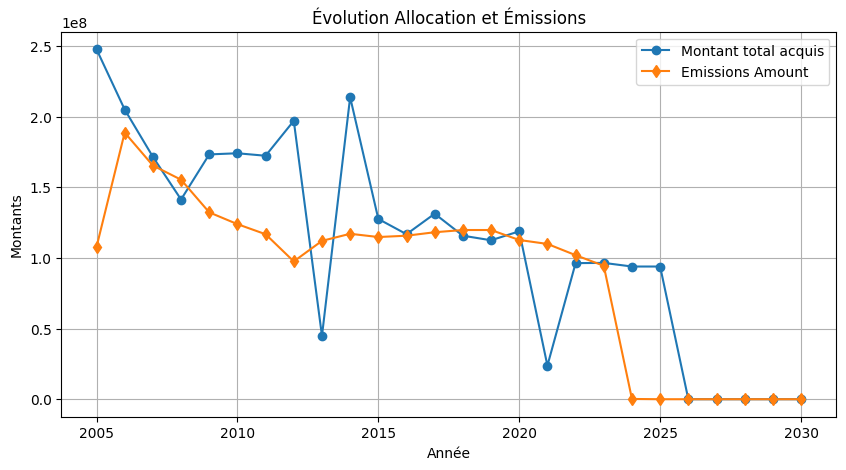

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Tracer les courbes
plt.plot(df_merged["Year"], df_merged["Montant total acquis"], label="Montant total acquis", marker="o")
plt.plot(df_merged["Year"], df_merged["Emissions Amount"], label="Emissions Amount", marker="d")

# Ajouter des légendes et titres
plt.xlabel("Année")
plt.ylabel("Montants")
plt.title("Évolution Allocation et Émissions")
plt.legend()
plt.grid(True)

#  Affichage du graphique
plt.show()